# Import Core Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

# Load Dataset

In [2]:
%run load_dataset.ipynb

Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 1009's data
Loading 1010's data
Loading 1011's data
Loading 1012's data
Loading 2001's data
Loading 2002's data
Finished loading


# Data Preprocessing

In [3]:
%run preprocess_for_SVM.ipynb
# includes wavelet denoising, normalization, PCA, LDA, SVD, etc.

In [4]:
print(X_all.shape, y_all.shape)

(27949, 3) (27949,)


# Group Data by Label and Normalize Data *

In [5]:
print(label_list)

['sit', 'sleep', 'stairs', 'stand', 'walk']


In [6]:
# denoise the signal using wavelet transform
# wavelet_output = wavelet_smooth(X_all)
# X_w = np.array(wavelet_output)

In [7]:
new_label_list = [0,1,3,2,4]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    3: 'stand',
    2: 'stairs',
    4: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [8]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all, y_all, subj_all, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

In [9]:
# plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [10]:
roll, pitch, yaw = calc_rpy(X_all, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

print(rpy.shape)

(27949, 3)


# Apply PCA and LDA

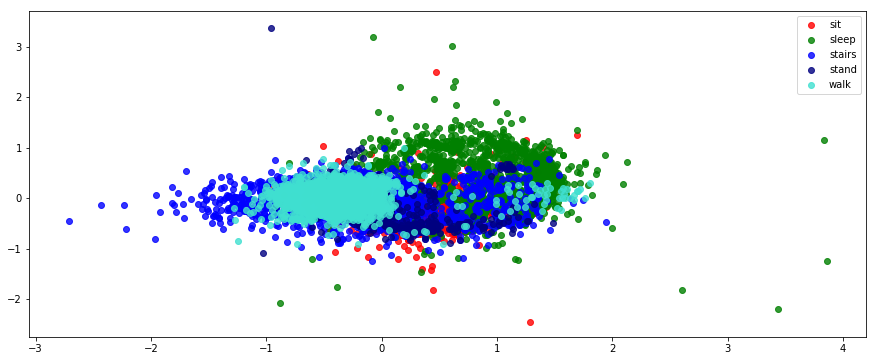

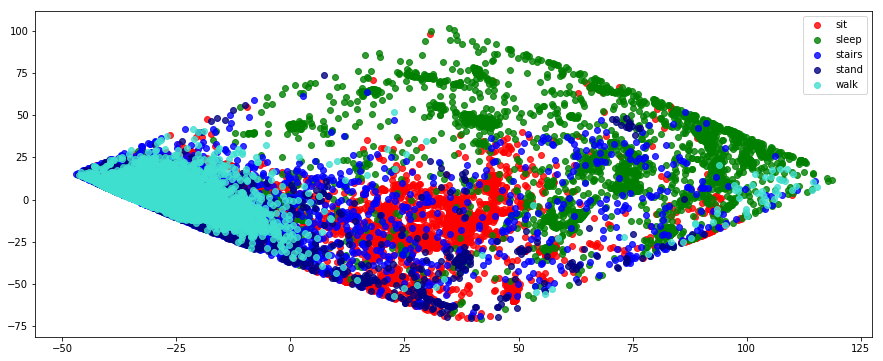

In [11]:
# apply PCA and LDA to X_norm and rpy
X_pca = apply_pca(X_all, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)

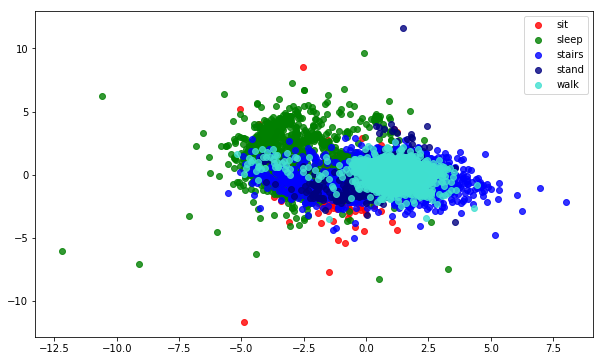

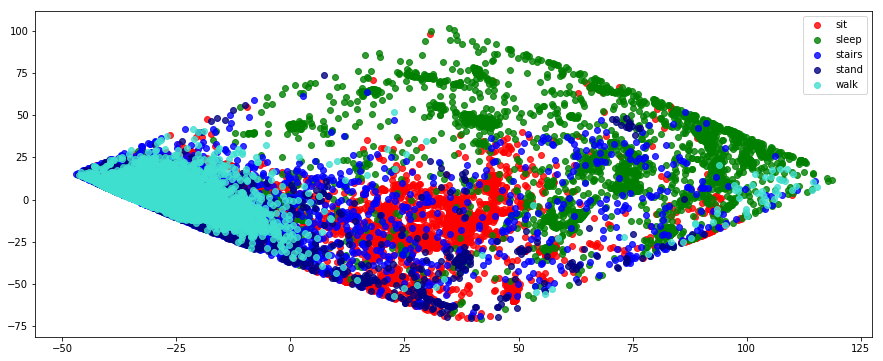

In [12]:
X_lda = apply_lda(X_all, y_all, label_list)
rpy_lda = apply_pca(rpy, y_all, label_list)

# Reshape Data (Pure Label)

In [13]:
# get label-separated X and y
X_svm, y_svm = prepare_pure_label(X_pca, y_all, subj_all, new_label_list)
y_svm = y_svm.reshape((y_svm.shape[0],))

In [14]:
print(X_svm.shape, y_svm.shape)

(23819, 180) (23819,)


# Reshape Data (Impure Label)

In [15]:
X_impure, y_impure = prepare_impure_label(X_pca, y_all)

In [16]:
print(X_impure.shape, y_impure.shape)

(27890, 180) (27890,)


# Split Train and Test Set

In [17]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

X_tr, X_te, y_tr, y_te = train_test_split(X_impure, y_impure, test_size=0.3, random_state=42)

print(X_tr.shape)
print(X_te.shape)

(19523, 180)
(8367, 180)


# SVM

In [18]:
svm_model = svm_classifier(X_train, y_train)
print("Finished training")

Finished training


In [19]:
y_pred_svm = svm_model.predict(X_test)

## SVM Evaluation

In [20]:
%run eval_score.ipynb

In [21]:
LABELS = ['sit','sleep','stairs','stand','walk']

0.8018471872376155


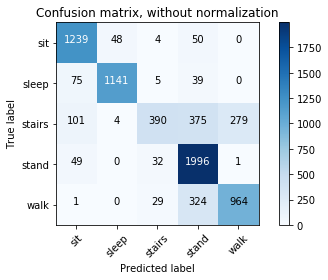

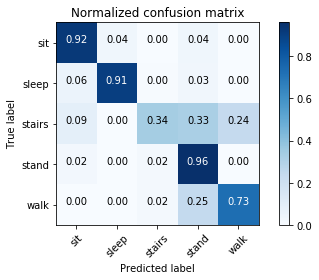

             precision    recall  f1-score   support

        sit       0.85      0.92      0.88      1341
      sleep       0.96      0.91      0.93      1260
     stairs       0.85      0.34      0.48      1149
      stand       0.72      0.96      0.82      2078
       walk       0.77      0.73      0.75      1318

avg / total       0.82      0.80      0.79      7146



In [22]:
acc = accuracy_score(y_test, y_pred_svm)
print(acc)

show_conf_matrix(y_test, y_pred_svm, LABELS)
show_clf_report(y_test, y_pred_svm, LABELS)

# K-NN

In [23]:
nn_model = nn_classifier(X_train, y_train)
print("Finished training")

Finished training


In [24]:
y_pred_nn = nn_model.predict(X_test)

## K-NN Evaluation

0.7934508816120907


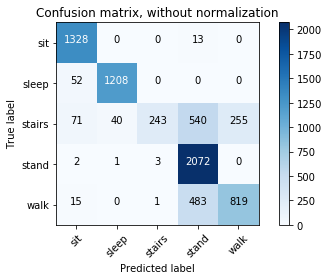

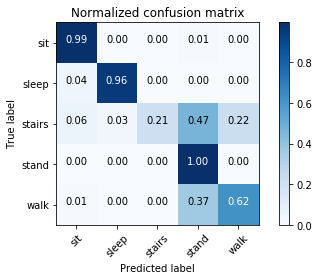

             precision    recall  f1-score   support

        sit       0.90      0.99      0.95      1341
      sleep       0.97      0.96      0.96      1260
     stairs       0.98      0.21      0.35      1149
      stand       0.67      1.00      0.80      2078
       walk       0.76      0.62      0.68      1318

avg / total       0.83      0.79      0.76      7146



In [25]:
acc = accuracy_score(y_test, y_pred_nn)
print(acc)

show_conf_matrix(y_test, y_pred_nn, LABELS)
show_clf_report(y_test, y_pred_nn, LABELS)

# Walk Algorithm

In [26]:
%run classifier_alg.ipynb

In [27]:
# classify walking
walk = calc_walk(X_all)
walk_its = intersection_walk(walk)
walk_pred_p = calc_walk_periods(walk_its)

walk_stairs_exact_p = get_exact_walk_stairs(y_all)
walk_exact_p = get_exact_walk(y_all)
    
walk_pred = binarize_walk_prd(walk_pred_p, y_all)
walk_stairs_exact = binarize_walk_prd(walk_stairs_exact_p, y_all)
walk_exact = binarize_walk_prd(walk_exact_p, y_all)

## Walk Algorithm Evaluation

In [28]:
walk_lbl = ['NaN','walk']

0.8383841997924791


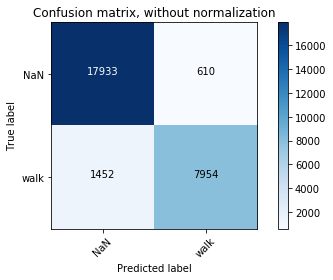

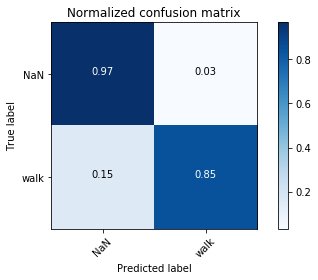

             precision    recall  f1-score   support

        NaN       0.93      0.97      0.95     18543
       walk       0.93      0.85      0.89      9406

avg / total       0.93      0.93      0.93     27949



In [29]:
acc = accuracy_score(walk_exact, walk_pred)
print(acc)

show_conf_matrix(walk_stairs_exact, walk_pred, walk_lbl)
show_clf_report(walk_stairs_exact, walk_pred, walk_lbl)

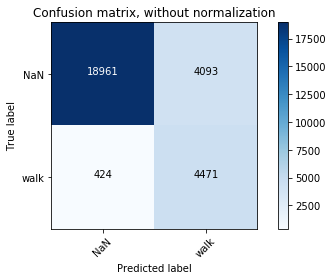

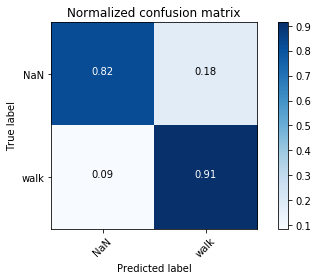

             precision    recall  f1-score   support

        NaN       0.98      0.82      0.89     23054
       walk       0.52      0.91      0.66      4895

avg / total       0.90      0.84      0.85     27949



In [30]:
show_conf_matrix(walk_exact, walk_pred, walk_lbl)
show_clf_report(walk_exact, walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [31]:
X_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
X_non_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

X_walk = np.array(X_walk)
X_non_walk = np.array(X_non_walk)

y_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
y_non_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

y_walk = np.array(y_walk)
y_non_walk = np.array(y_non_walk)

In [32]:
print(X_walk.shape, X_non_walk.shape)
print(y_walk.shape, y_non_walk.shape)

(8564, 3) (19385, 3)
(8564,) (19385,)


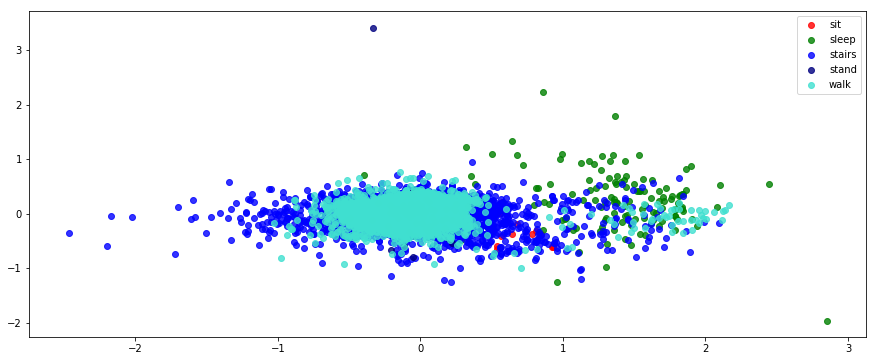

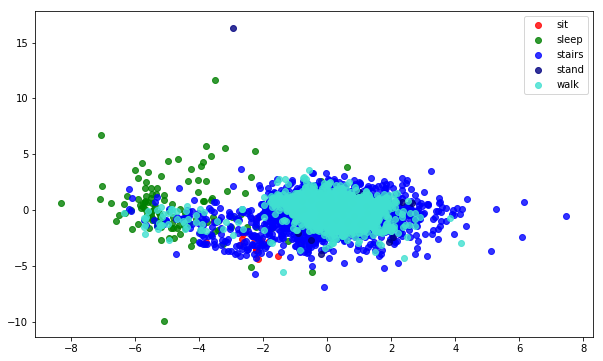

In [33]:
Xw_pca = apply_pca(X_walk, y_walk, label_list)
Xw_lda = apply_lda(X_walk, y_walk, label_list)

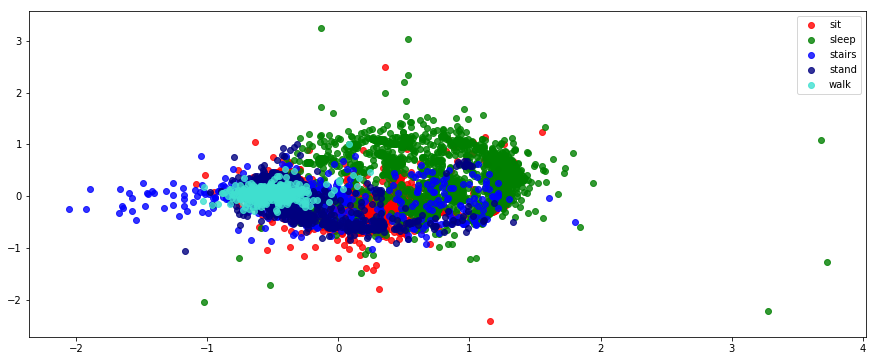

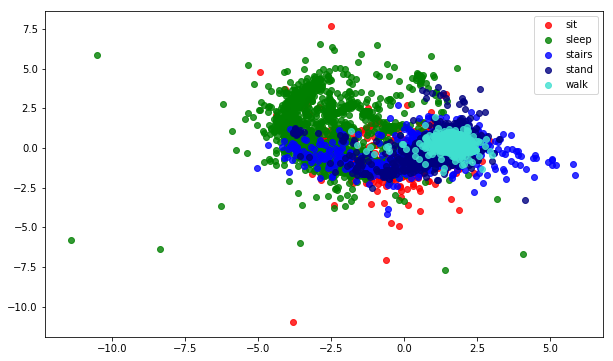

In [34]:
Xnw_pca = apply_pca(X_non_walk, y_non_walk, label_list)
Xnw_lda = apply_lda(X_non_walk, y_non_walk, label_list)

In [35]:
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw_lda, y_walk, test_size=0.3, random_state=42)

Xnw_train, Xnw_test, ynw_train, ynw_test = train_test_split(Xnw_lda, y_non_walk, test_size=0.3, random_state=42)

In [36]:
svm_walk = svm_classifier(Xw_train, yw_train)
print("Finish Training")

Finish Training


In [37]:
svm_non_walk = svm_classifier(Xnw_train, ynw_train)
print("Finish Training")

Finish Training


In [38]:
yw_pred = svm_walk.predict(Xw_test)
ynw_pred = svm_non_walk.predict(Xnw_test)

0.6914396887159533


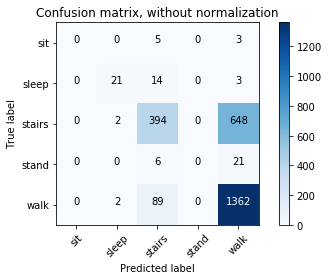

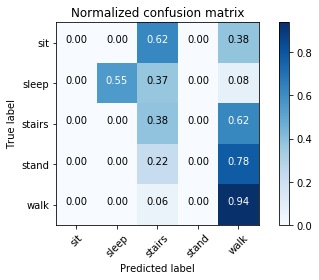

             precision    recall  f1-score   support

        sit       0.00      0.00      0.00         8
      sleep       0.84      0.55      0.67        38
     stairs       0.78      0.38      0.51      1044
      stand       0.00      0.00      0.00        27
       walk       0.67      0.94      0.78      1453

avg / total       0.71      0.69      0.66      2570



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
acc = accuracy_score(yw_test, yw_pred)
print(acc)

show_conf_matrix(yw_test, yw_pred, LABELS)
show_clf_report(yw_test, yw_pred, LABELS)

0.8607290233837689


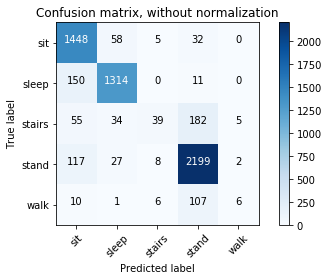

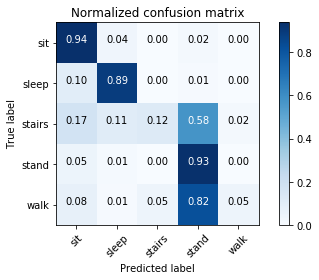

             precision    recall  f1-score   support

        sit       0.81      0.94      0.87      1543
      sleep       0.92      0.89      0.90      1475
     stairs       0.67      0.12      0.21       315
      stand       0.87      0.93      0.90      2353
       walk       0.46      0.05      0.08       130

avg / total       0.85      0.86      0.84      5816



In [40]:
acc = accuracy_score(ynw_test, ynw_pred)
print(acc)

show_conf_matrix(ynw_test, ynw_pred, LABELS)
show_clf_report(ynw_test, ynw_pred, LABELS)

# Test Model with Some Subject

In [65]:
test_subj = '1003'
filepath = 'DDC_Data/' + test_subj + '/' + test_subj + '-log_acc.csv'

df_test = pd.read_csv(filepath, header=None, names=['x','y','z','timestamp'])

In [66]:
ts_list = []
g = 9.8

for i in range(len(df_test)):
    X_i = [df_test.loc[i]['x']/g, df_test.loc[i]['y']/g, df_test.loc[i]['z']/g]
    ts_list.append(df_test.loc[i]['timestamp'])
    
    if(i==0):
        X_visua = X_i
    else:
        X_visua = np.vstack((X_visua, X_i))

ts_list = np.array(ts_list)

In [67]:
n_comp = 3

pca = PCA(n_components=n_comp)
pca = pca.fit(X_all)
X_vis_pca = pca.transform(X_visua)

In [68]:
X_vis_imp, ts_list_imp = prepare_impure_label(X_vis_pca, ts_list)

In [69]:
y_t_pred = svm_model.predict(X_vis_imp)

In [70]:
y_dict = {}
y_dict['timestamp'] = ts_list_imp
y_dict['y_pred'] = y_t_pred

df_y = pd.DataFrame(y_dict)

df_y['y_pred'].value_counts()

3    1295
0    1288
1     766
4     640
2     481
Name: y_pred, dtype: int64

# Test SVM Model with Data from One Subject

In [71]:
timer_path = 'DDC_Data/' + test_subj + '/' + test_subj + '-iphone-history_amdtimer 6.csv'

cols = ['sid', 'timestamp', 'duration', 'label']
df_timer = pd.read_csv(timer_path, header=None, names=['sid','label','timestamp', 'duration'])
sid_list = np.array(list(df_timer['sid']))

tf = list(map(lambda x: x==int(test_subj), sid_list))
df_sid = df_timer[tf]
df_sid = df_sid.reset_index(drop=True)

# Group a Sequence into Periods by Labels

In [72]:
label_period = []
period_list = [[] for i in range(len(LABELS))]

first = 0
keep = 0

for i in range(len(df_y)):
    if(calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])>=calc_sec(df_sid.loc[0]['timestamp'].split(' ')[1]) and
       calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])<=calc_sec(df_sid.loc[len(df_sid)-1]['timestamp'].split(' ')[1])):
        
        keep_lb = df_y.loc[keep]['y_pred']

        if(keep_lb!=df_y.loc[i]['y_pred']):
            label_period.append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp'], 
                                 df_y.loc[i-1]['y_pred']])

            period_list[df_y.loc[i-1]['y_pred']].append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp']])

            keep = i

# Display Table

In [62]:
from prettytable import PrettyTable

In [73]:
labels_list = ['sit', 'sleep', 'stairs', 'stand', 'walk']
headers = ['start', 'end', 'label']

t = PrettyTable(headers)

for row in label_period:
    t.add_row([row[0], row[1], labels_list[row[2]]])

In [74]:
print(t)

+-------------------------+-------------------------+--------+
|          start          |           end           | label  |
+-------------------------+-------------------------+--------+
| 2019-01-14 15:43:32.428 | 2019-01-14 15:46:12.937 | stand  |
| 2019-01-14 15:46:13.098 | 2019-01-14 15:46:49.106 | stand  |
| 2019-01-14 15:46:49.265 | 2019-01-14 15:47:26.716 |  sit   |
| 2019-01-14 15:47:26.876 | 2019-01-14 15:48:07.223 | stand  |
| 2019-01-14 15:48:07.383 | 2019-01-14 15:48:09.956 | stairs |
| 2019-01-14 15:48:10.117 | 2019-01-14 15:48:15.579 |  sit   |
|  2019-01-14 15:48:15.74 | 2019-01-14 15:48:17.186 | sleep  |
| 2019-01-14 15:48:17.348 |  2019-01-14 15:48:17.99 |  sit   |
|  2019-01-14 15:48:18.15 | 2019-01-14 15:48:44.832 | sleep  |
| 2019-01-14 15:48:44.991 |  2019-01-14 15:48:46.92 | stairs |
| 2019-01-14 15:48:47.081 | 2019-01-14 15:48:50.135 | sleep  |
| 2019-01-14 15:48:50.296 | 2019-01-14 15:49:17.619 |  sit   |
| 2019-01-14 15:49:17.779 | 2019-01-14 15:49:17.779 | s

In [75]:
df_sid[cols]

,sid,timestamp,duration,label
0,1003,2019-01-14 15:46:12.978,00:00:30,stand
1,1003,2019-01-14 15:46:47.359,00:00:30,sit
2,1003,2019-01-14 15:47:20.869,00:00:30,stand
3,1003,2019-01-14 15:48:11.689,00:00:30,sleep
4,1003,2019-01-14 15:48:45.659,00:00:32,sit
5,1003,2019-01-14 15:49:24.555,00:00:30,sleep
6,1003,2019-01-14 15:50:01.009,00:00:30,stand
7,1003,2019-01-14 15:51:10.240,00:01:00,walk
8,1003,2019-01-14 15:52:41.083,00:00:14,downstairs
9,1003,2019-01-14 15:52:56.493,00:00:13,upstairs


# Predicted Duration

In [76]:
total_secs = []
for i in range(len(period_list)):    
    secs = 0
    for p_i in period_list[i]:
        secs += calc_sec(p_i[1].split(' ')[1]) - calc_sec(p_i[0].split(' ')[1])
    
    secs = round(secs, 3)
    total_secs.append(secs)
    
percent_secs = [round(t/np.sum(total_secs)*100, 3) for t in total_secs]

tb = PrettyTable(['Label', 'Seconds', 'Percentage'])

for i in range(len(LABELS)):
    tb.add_row([labels_list[i], total_secs[i], percent_secs[i]])

tb.add_row(['', '', ''])
tb.add_row(['total', round(np.sum(total_secs), 3), round(np.sum(percent_secs), 3)])

In [77]:
print(tb)

+--------+---------+------------+
| Label  | Seconds | Percentage |
+--------+---------+------------+
|  sit   |  98.19  |   17.097   |
| sleep  |  65.251 |   11.361   |
| stairs |  55.124 |   9.598    |
| stand  | 285.701 |   49.746   |
|  walk  |  70.054 |   12.198   |
|        |         |            |
| total  |  574.32 |   100.0    |
+--------+---------+------------+


# Actual Duration

In [78]:
df_lb = df_sid.groupby('label')
old_labels_list = ['sit', 'sleep', 'downstairs', 'upstairs', 'stand', 'walk']

dura_dict = {}
for lb in labels_list:
    dura_dict[lb] = 0

idx = list(df_sid.index)
for i in range(len(old_labels_list)):
    lb = old_labels_list[i]
    df_temp = df_lb.get_group(lb)
    df_temp = df_temp.reset_index(drop=True)
        
    if(lb=='downstairs' or lb=='upstairs'):
        lb = 'stairs'
    
    for j in range(len(df_temp)):
        dura_dict[lb] += calc_sec(df_temp.loc[j]['duration'])

total_dura = np.sum([dura_dict[lb] for lb in labels_list])

percent_list = []
        
tabl = PrettyTable(['Label', 'Seconds', 'Percentage'])
for lb in labels_list:
    percent = round(dura_dict[lb]/total_dura*100, 3)
    tabl.add_row([lb, dura_dict[lb], round(dura_dict[lb]/total_dura*100, 3)])
    
    percent_list.append(percent)
    
tabl.add_row(['', '', ''])    
tabl.add_row(['total', round(total_dura, 3), np.sum(percent_list)])

In [79]:
print(tabl)

+--------+---------+------------+
| Label  | Seconds | Percentage |
+--------+---------+------------+
|  sit   |   62.0  |   18.96    |
| sleep  |   60.0  |   18.349   |
| stairs |   55.0  |   16.82    |
| stand  |   90.0  |   27.523   |
|  walk  |   60.0  |   18.349   |
|        |         |            |
| total  |  327.0  |  100.001   |
+--------+---------+------------+
